<a href="https://colab.research.google.com/github/pullakkagarisaiteja/CN7030-2425-Machine-Learning-on-Big-Data-/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install pyspark
!pip3 install pyspark

In [60]:
#initialize SparkSession and installed Required Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


spark

In [61]:
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark UI available at: http://08267c69e57d:4040


In [4]:
spark.sparkContext.setLogLevel("INFO")

In [5]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 21.7%
Memory Usage: 10.6%


In [7]:
# Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
# Load the data from a CSV file
df = spark.read.csv("/content/property.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print("Total Records",df.count())
print("Total Partitions ",df.rdd.getNumPartitions())

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
|          3944|           6|            2|      1938|    3542| 845638.1354384426|
|          3671|           2|            1|      1963|    5105| 748779.2192281872|
|          3419|           4|            2|      1925|    5448| 743007.2614135538|
|           630|           2|            2|      2012|    3204| 135656.4528785377|
|   

In [63]:
# show Schema,Prints the structure of the dataset
df.printSchema()

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)



In [64]:
#Statistical Analysis
df.describe().show()

+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|   Square_Footage|     Num_Bedrooms|     Num_Bathrooms|       Year_Built|         Lot_Size|             Price|
+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|          1000000|          1000000|           1000000|          1000000|          1000000|           1000000|
|   mean|      2750.657104|         3.501114|          2.500439|       1960.52736|      5502.373911| 581839.6653163614|
| stddev|1298.569362387213|1.708173784151257|1.1178528780094728|35.21780350510348|2598.885882999355|260685.36722644986|
|    min|              500|                1|                 1|             1900|             1000| 51495.71116919513|
|    max|             4999|                6|                 4|             2021|             9999|1123219.4691521737|
+-------+-----------------+-------------

In [65]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 34.4%
Memory Usage after csv file: 17.6%


In [66]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c))
.alias(c) for c in df.columns]).show()

+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [67]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms","Year_Built","Lot_Size","Price"],
                           outputCol = "Features")

In [35]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")

In [68]:
#create linear regression model.
regressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features'
                             )

In [70]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 14.6%
Memory Usage after csv file: 18.2%


In [71]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LRsaved_model")

In [72]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 17.7%
Memory Usage after csv file: 18.2%


In [73]:
#Loading the Pipeline

pipelineModel = Pipeline.load('./pipeline_LRsaved_model')

In [74]:
data_train , data_test = df.randomSplit([0.7,0.3], seed = 123)

In [75]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 57.9%
Memory Usage after csv file: 18.4%


In [76]:
Model = pipeline.fit(data_train)

In [77]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 91.8%
Memory Usage after csv file: 18.5%


In [78]:
print("total LR cofficents",len(Model.stages[2].coefficients) )
print("Cofficientents",Model.stages[2].coefficients)
print("Intecept",Model.stages[2].intercept)

total LR cofficents 6
Cofficientents [-1.4597928877506778e-06,-3.5146841056385616e-08,-1.2636801886279531e-08,1.7753088636142828e-07,1.883210751840152e-08,260678.5660076505]
Intecept -1.0061060249262389e-05


In [79]:
#n the prediction phase, we test our model on some unseen data.
pred = Model.transform(data_test)
pred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|117632.63219933254|117632.63219959654|
|106670.25438515098|106670.25438504865|
|117919.45375856124|117919.45375887671|
|119893.50473273186|119893.50473253023|
|115218.14440396686|115218.14440379351|
|142918.60554288875|142918.60554292126|
|95443.54011647665 |95443.54011673816 |
|75029.23686158785 |75029.23686169085 |
|128827.18170759646|128827.18170769783|
|131723.4490399875 |131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [80]:
#create linear regression model.
Lasoregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [81]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 97.1%
Memory Usage after csv file: 18.2%


In [82]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|117865.1250943526 |117632.63219959654|
|107822.86196143829|106670.25438504865|
|119904.75326061211|117919.45375887671|
|117562.37474359476|119893.50473253023|
|115027.9382832686 |115218.14440379351|
|137148.23142596747|142918.60554292126|
|104452.42723755688|95443.54011673816 |
|88657.40457025377 |75029.23686169085 |
|127422.78042103843|128827.18170769783|
|130383.81735629286|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [52]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)

In [54]:
#n the prediction phase, we test our model on some unseen data.
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|117632.66402244041|117632.63219959654|
|106670.45946237333|106670.25438504865|
|117919.82387435198|117919.45375887671|
|119893.04361457757|119893.50473253023|
|115218.09475159772|115218.14440379351|
|142917.49094270985|142918.60554292126|
|95445.25419980078 |95443.54011673816 |
|75031.83383794635 |75029.23686169085 |
|128826.90148789567|128827.18170769783|
|131723.18284653392|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [58]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol =
                                    'Price',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(pred)
mselasso = evaluator_mse.evaluate(lassopred)
mseridge = evaluator_mse.evaluate(Ridgepred)

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'Price',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'Price',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)

evaluator_mae = RegressionEvaluator(labelCol = 'Price',
                                    predictionCol = 'prediction',
                                    metricName = 'mae')
# calculate MAE
mae1 = evaluator_mae.evaluate(pred)
maelasso = evaluator_mae.evaluate(lassopred)
maeridge = evaluator_mae.evaluate(Ridgepred)


# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1, ', MAE: ', mae1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso, ', MAE: ', maelasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge, ', MAE: ', maeridge)

Regression - MSE:  3.903843172336979e-14 , RMSE:  1.9758145591975423e-07 , R^2:  1.0 , MAE:  1.6233466735170593e-07
Lasso - MSE:  45938250.20878146 , RMSE:  6777.7761993725835 , R^2:  0.9993240889793171 , MAE:  5411.397683399603
Ridge - MSE:  1.6874276839011937 , RMSE:  1.2990102708990385 , R^2:  0.9999999999751721 , MAE:  1.0371305269102158


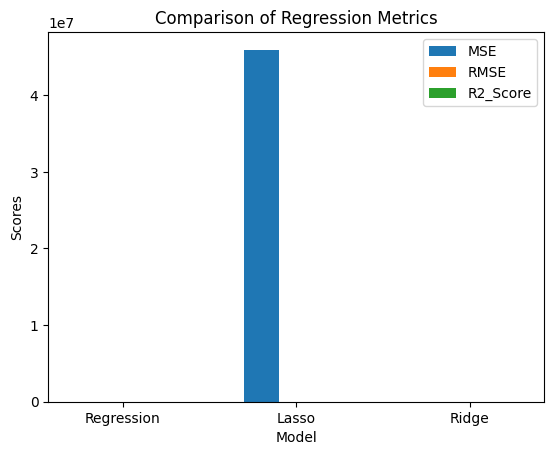

In [59]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()
